
## **How to Use This Dashboard**

This dashboard provides a detailed visualization of COVID-19 metrics, such as daily hospital admissions and the number of occupied hospital beds. It allows users to explore the data interactively.

### **Steps to Navigate the Dashboard**

1. **Filter Data by Year**
   - Use the **Year dropdown** to select the year for which you want to view data.
   - The graph updates automatically to show data only for the selected year.

2. **Choose Metrics to Display**
   - Use the **Metrics multi-select widget** to choose one or more data metrics to display on the graph:
     - `admissions`: Displays daily hospital admissions due to COVID-19.
     - `occupied beds`: Displays the number of beds occupied by COVID-19 patients.
   - Hold **Ctrl (Windows/Linux)** or **Cmd (Mac)** to select multiple options.

3. **Change the Scale of the Graph**
   - Use the **Scale radio buttons** to toggle between:
     - **Linear Scale**: Provides a standard visualization of the data.
     - **Logarithmic Scale**: Helps identify trends over a wide range of values.

4. **Refresh the Data**
   - Click the **Refresh Data button** to simulate fetching the latest data.
   - The dashboard updates dynamically with refreshed information, and all widgets reflect the updated data.

### **Graph Features**
- The graph provides a clear visualization of trends over time.
- It includes legends, titles, and gridlines for better understanding.
- Data points are displayed dynamically based on user selections.


In [11]:
import requests  #Library to make HTTP requests
import time  #Library for handling delays and timing
import json  #Library for saving and reading JSON data

class APIwrapper:
    """
    A class to interact with the UKHSA API for fetching COVID-19 metrics.
    """
    _access_point = "https://api.ukhsa-dashboard.data.gov.uk"
    _last_access = 0.0  #Track the time of the last API request for rate limiting

    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """
        Initialize the APIwrapper with parameters to construct the API endpoint.
        """
        #Construct the API endpoint dynamically using provided parameters, this was not needed but I believe it better for reusability.
        url_path = (f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/"
                    f"{geography_type}/geographies/{geography}/metrics/{metric}")
        self._start_url = APIwrapper._access_point + url_path  # Full URL
        self._filters = None  # Filters to apply to API requests
        self._page_size = -1  #This is the default page size
        self.count = None  # and.....Total number of records available for the query

    def get_page(self, filters={}, page_size=5):
        """
        Fetch a single page of data from the API. Filters and page size can be adjusted.
        """
        if page_size > 365:  # To ensure the page size is within the allowable range
            raise ValueError("Max supported page size is 365")

        # Restart fetching data if filters or page size change
        if filters != self._filters or page_size != self._page_size:
            self._filters = filters
            self._page_size = page_size
            self._next_url = self._start_url

        if self._next_url is None:  # If there are no more pages stop fetching!
            return []

        # Rate limiting to avoid overwhelming the API. WE DO NOT WANT TO GET BANNED
        curr_time = time.time()
        if curr_time - APIwrapper._last_access < 0.33:  # Limit to 3 requests per second
            time.sleep(0.33 - (curr_time - APIwrapper._last_access))
        APIwrapper._last_access = curr_time

        # Build request parameters by removing any `None` values
        parameters = {key: value for key, value in filters.items() if value is not None}
        parameters['page_size'] = page_size

        # Make the API request and parse the response
        response = requests.get(self._next_url, params=parameters).json()
        self._next_url = response.get('next')  # URL for the next page, if any
        self.count = response.get('count')  # Total number of data points available
        return response.get('results', [])  # Return the data points in the current page

    def get_all_pages(self, filters={}, page_size=365):
        """
        Fetch all pages of data from the API. Combines multiple pages into one list.
        """
        data = []  # List to store all data points
        while True:
            next_page = self.get_page(filters, page_size)
            if not next_page:  # Stop if there are no more pages
                break
            data.extend(next_page)  # Add the data points from the current page
        return data


# Define the structure for the API request
structure = {
    "theme": "infectious_disease",  # Broad theme (e.g., infectious diseases)
    "sub_theme": "respiratory",  # Sub-theme within the broad theme
    "topic": "COVID-19",  # Specific topic
    "geography_type": "Nation",  # Type of geographical division
    "geography": "England"  # Specific geography
}

# The data is fetched and saved data for beds occupied due to COVID-19
structure["metric"] = "COVID-19_healthcare_occupiedBedsByDay"
api = APIwrapper(**structure)
occupied_beds_data = api.get_all_pages()


with open("occupied_beds_data.json", "w") as file:
    json.dump(occupied_beds_data, file, indent=4)  
print(f"Occupied beds data saved to 'occupied_beds_data.json'") #Saved the data for occupied into to a JSON file

# Fetch and save data for COVID-19 admissions
structure["metric"] = "COVID-19_healthcare_admissionByDay"
api = APIwrapper(**structure)
admissions_data = api.get_all_pages()

# Save admissions data to a JSON file
with open("admissions_data.json", "w") as file:
    json.dump(admissions_data, file, indent=4)  # Indented so it's much more easy to read
print(f"Admissions data saved to 'admissions_data.json'")



Occupied beds data saved to 'occupied_beds_data.json'
Admissions data saved to 'admissions_data.json'


2020-08-01 00:00:00  to  2024-10-31 00:00:00
DataFrame saved to timeseriesdf.pkl


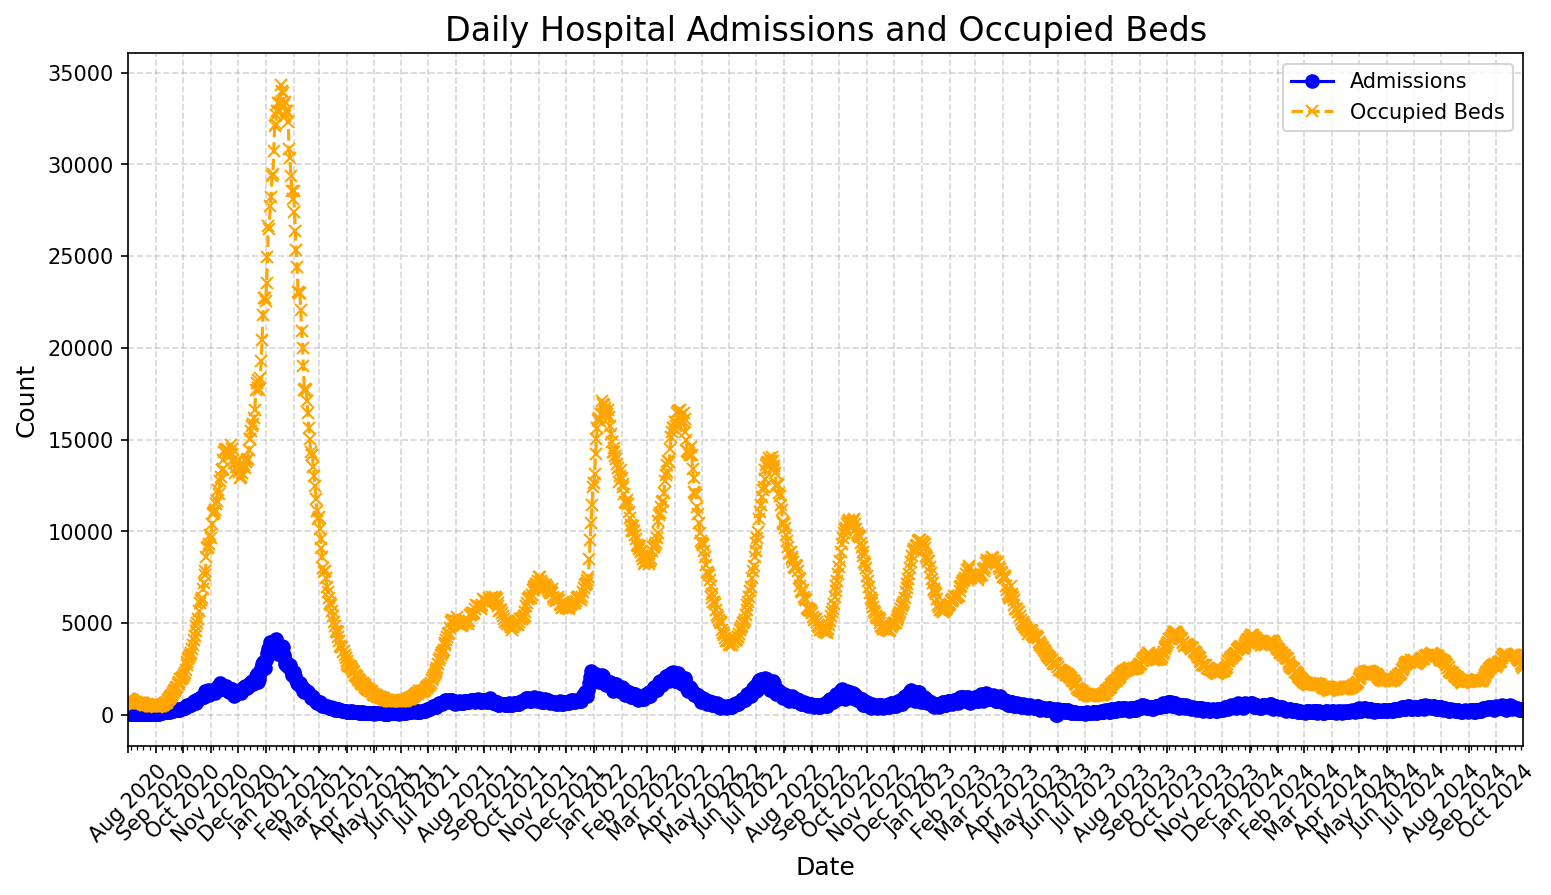

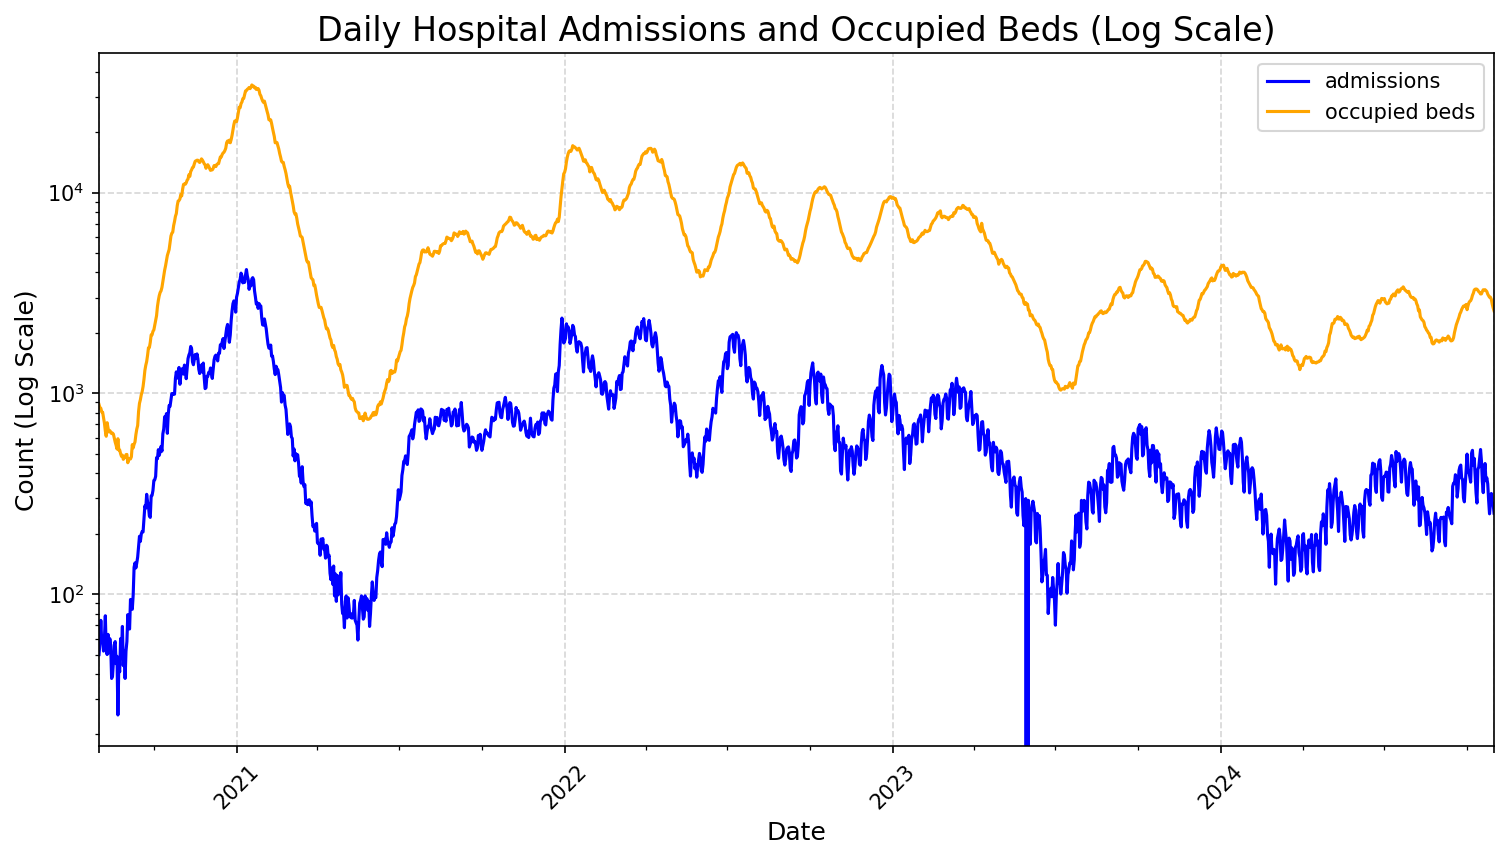

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Make figures larger and improve display quality
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12, 6)  # Set default figure size

# Load data from JSON files
with open("admissions_data.json", "r") as file:
    admissions_data = json.load(file)

with open("occupied_beds_data.json", "r") as file:
    occupied_beds_data = json.load(file)

# Preview the first few entries of the occupied beds dataset
occupied_beds_data[:5]

# Combine data from admissions and occupied beds into a single dictionary
data = {}
for dataset in [admissions_data, occupied_beds_data]:
    for entry in dataset:
        date = entry['date']
        metric = entry['metric']
        value = entry['metric_value']
        # Group data by date and metric
        if date not in data:
            data[date] = {}
        data[date][metric] = value

# Check the data for a specific date
data['2024-01-30']

# Extract and sort dates
dates = list(data.keys())
dates.sort()

# Function to parse date strings into Pandas datetime objects
def parse_date(datestring):
    """Convert a date string into a pandas datetime object."""
    return pd.to_datetime(datestring, format="%Y-%m-%d")

# Define the date range based on available data
startdate = parse_date(dates[0])
enddate = parse_date(dates[-1])
print(startdate, " to ", enddate)

# Create an empty DataFrame with a daily date range
index = pd.date_range(startdate, enddate, freq='D')
timeseriesdf = pd.DataFrame(index=index, columns=['admissions', 'occupied beds'])

# Define metric mappings
metrics = {
    'occupied beds': 'COVID-19_healthcare_occupiedBedsByDay',
    'admissions': 'COVID-19_healthcare_admissionByDay',
}

# Populate the DataFrame with data
for date, entry in data.items():
    pd_date = parse_date(date)  # Convert to Pandas format
    for column in ['admissions', 'occupied beds']:
        metric_name = metrics[column]
        # Insert 0.0 if a value is missing
        value = entry.get(metric_name, 0.0)
        timeseriesdf.loc[date, column] = value

# Fill missing values in the DataFrame with 0.0
timeseriesdf.fillna(0.0, inplace=True)

# Save the processed DataFrame to a pickle file for reuse
timeseriesdf.to_pickle("timeseriesdf.pkl")
print("DataFrame saved to timeseriesdf.pkl")

# Plotting the data with enhanced visualization
fig, ax = plt.subplots()

# Plot hospital admissions and occupied beds
timeseriesdf['admissions'].plot(ax=ax, label='Admissions', linestyle='-', marker='o', color='blue')
timeseriesdf['occupied beds'].plot(ax=ax, label='Occupied Beds', linestyle='--', marker='x', color='orange')

# Add a grid and labels for better readability
ax.set_title("Daily Hospital Admissions and Occupied Beds", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.5)

# Format the x-axis to show fewer, rotated date labels
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks every month
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())  # Minor ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # Format as 'Month Year'
plt.xticks(rotation=45, fontsize=10)

# Add a second visualization with a log scale for clarity
fig, ax_log = plt.subplots()
timeseriesdf.plot(ax=ax_log, logy=True, color=['blue', 'orange'])
ax_log.set_title("Daily Hospital Admissions and Occupied Beds (Log Scale)", fontsize=16)
ax_log.set_xlabel("Date", fontsize=12)
ax_log.set_ylabel("Count (Log Scale)", fontsize=12)
ax_log.legend(fontsize=10)
ax_log.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, fontsize=10)

plt.show()


In [14]:
from IPython.display import clear_output, display
import ipywidgets as wdg
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

# Configure Matplotlib for Jupyter Notebook
%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (10, 5)

# Load pre-saved time series data from a pickle file
timeseriesdf = pd.read_pickle("timeseriesdf.pkl")

# Extract available years from the data
available_years = sorted(timeseriesdf.index.year.unique())

# Widget: Dropdown to filter by year
year_selector = wdg.Dropdown(
    options=available_years,
    value=available_years[0],  # Default to the first available year
    description='Year:',
    disabled=False
)

# Widget: Select multiple data series for the graph
series_selector = wdg.SelectMultiple(
    options=['admissions', 'occupied beds'],
    value=['admissions', 'occupied beds'],  # Default selected values
    rows=2,
    description='Metrics:',
    disabled=False
)

# Widget: Radio buttons for selecting scale
scale_selector = wdg.RadioButtons(
    options=['linear', 'log'],  # Choices for the graph scale
    value='linear',
    description='Scale:',
    disabled=False
)

# Refresh Button
refresh_button = wdg.Button(
    description='Refresh Data',
    disabled=False,
    button_style='success',  # Green button
    tooltip='Click to refresh the data from the API',
    icon='refresh'
)

def refresh_data():
    """
    Function to reload and process data.
    """
    if not os.path.exists("admissions_data.json") or not os.path.exists("occupied_beds_data.json"):
        print("Error: Required JSON files are missing.")
        return timeseriesdf  # Return the existing DataFrame to avoid breaking the code

    with open("admissions_data.json", "r") as file:
        admissions_data = json.load(file)
    with open("occupied_beds_data.json", "r") as file:
        occupied_beds_data = json.load(file)

    data = {}
    for dataset in [admissions_data, occupied_beds_data]:
        for entry in dataset:
            date = entry['date']
            metric = entry['metric']
            value = entry['metric_value']
            if date not in data:
                data[date] = {}
            data[date][metric] = value

    dates = sorted(data.keys())
    index = pd.date_range(start=dates[0], end=dates[-1], freq='D')
    refreshed_df = pd.DataFrame(index=index, columns=['admissions', 'occupied beds'])

    metrics = {
        'occupied beds': 'COVID-19_healthcare_occupiedBedsByDay',
        'admissions': 'COVID-19_healthcare_admissionByDay',
    }
    for date, entry in data.items():
        pd_date = pd.to_datetime(date)
        for column, metric_name in metrics.items():
            value = entry.get(metric_name, 0.0)
            refreshed_df.loc[pd_date, column] = value

    refreshed_df.fillna(0.0, inplace=True)
    refreshed_df.to_pickle("timeseriesdf.pkl")
    return refreshed_df

def handle_refresh(button):
    """
    Callback function for the refresh button.
    """
    global timeseriesdf
    timeseriesdf = refresh_data()
    year_selector.options = sorted(timeseriesdf.index.year.unique())
    year_selector.value = year_selector.options[0]  # Force refresh

# Attach the refresh button
refresh_button.on_click(handle_refresh)

# Function to update the graph dynamically
def update_graph(selected_year, selected_metrics, selected_scale):
    if selected_scale == 'linear':
        log_scale = False
    else:
        log_scale = True

    filtered_df = timeseriesdf[timeseriesdf.index.year == selected_year]

    if selected_metrics:
        filtered_df[list(selected_metrics)].plot(logy=log_scale, linewidth=2)
        plt.title(f"COVID-19 Metrics for {selected_year}", fontsize=14)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=10)
        plt.show()
    else:
        print("Please select at least one metric to display.")

graph = wdg.interactive_output(
    update_graph,
    {
        'selected_year': year_selector,
        'selected_metrics': series_selector,
        'selected_scale': scale_selector
    }
)

controls = wdg.VBox([
    refresh_button,
    year_selector,
    series_selector,
    scale_selector
])

display(controls, graph)



Output()